In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in {models_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [3]:
# For each TF and each fold, find the best model in terms of validation loss
# and record its test profile NLL and count correlation
tfs = ["CEBPB", "E2F6", "GABPA", "JUND", "REST", "SPI1", "NR3C1", "FOXA2", "MAFK", "MAX"]

prof_nlls, count_corrs, last_epochs = {}, {}, {}

for tf in tfs:
    print("Fetching data for %s" % tf)
    prof_nlls[tf] = []
    count_corrs[tf] = []
    last_epochs[tf] = []
    for fold_num in range(1, 11):
        condition = "%s_fold%d" % (tf, fold_num)
        models_path = "/users/amtseng/tfmodisco/models/trained_models/%s/" % condition
        
        prof_nlls[tf].append([])
        count_corrs[tf].append([])
        last_epochs[tf].append([])
        for run_num in range(1, 4):
            metrics = import_metrics_json(models_path, run_num)

            prof_nlls[tf][-1].append(np.mean(metrics["summit_prof_nll"]["values"]))
            count_corrs[tf][-1].append(np.mean(metrics["summit_count_pearson"]["values"]))
            last_epochs[tf][-1].append(len(metrics["val_epoch_loss"]["values"]))

Fetching data for CEBPB
Fetching data for E2F6
Fetching data for GABPA
Fetching data for JUND
Fetching data for REST
Fetching data for SPI1
Fetching data for NR3C1
Fetching data for FOXA2
Fetching data for MAFK
Fetching data for MAX


In [4]:
# Best run for profile NLL
for tf in tfs:
    values = np.array(prof_nlls[tf])
    inds = np.where(values == np.min(values))
    print(tf + ":")
    best_fold, best_run = inds[0][0] + 1, inds[1][0] + 1
    last_epoch = last_epochs[tf][best_fold - 1][best_run - 1]
    
    print("\tFold: %d, Run: %d, Epoch: %d" % (best_fold, best_run, last_epoch))

CEBPB:
	Fold: 6, Run: 2, Epoch: 6
E2F6:
	Fold: 9, Run: 3, Epoch: 10
GABPA:
	Fold: 10, Run: 1, Epoch: 6
JUND:
	Fold: 6, Run: 1, Epoch: 3
REST:
	Fold: 6, Run: 2, Epoch: 4
SPI1:
	Fold: 7, Run: 1, Epoch: 8
NR3C1:
	Fold: 6, Run: 2, Epoch: 10
FOXA2:
	Fold: 6, Run: 3, Epoch: 5
MAFK:
	Fold: 6, Run: 2, Epoch: 6
MAX:
	Fold: 10, Run: 2, Epoch: 4


In [5]:
def plot_fold_consistency(tf_data_dict, ylabel):
    fig, ax = plt.subplots(len(tfs), 1, figsize=(10, 20), sharex=True, sharey=True)
    for i, tf in enumerate(tfs):
        xvals, yvals = [], []
        for j, vals in enumerate(tf_data_dict[tf]):
            xvals.extend([j + 1] * len(vals))
            yvals.extend(vals)
        ax[i].scatter(xvals, yvals)
        ax[i].set_title(tf, fontsize=16)
    plt.xlabel("Fold", fontsize=14)
    plt.xticks(range(1, 11))
    fig.text(0.06, 0.5, ylabel, ha="center", va="center", rotation="vertical", fontsize=14)
    fig.suptitle("Consistency of " + ylabel + " across folds", fontsize=16)

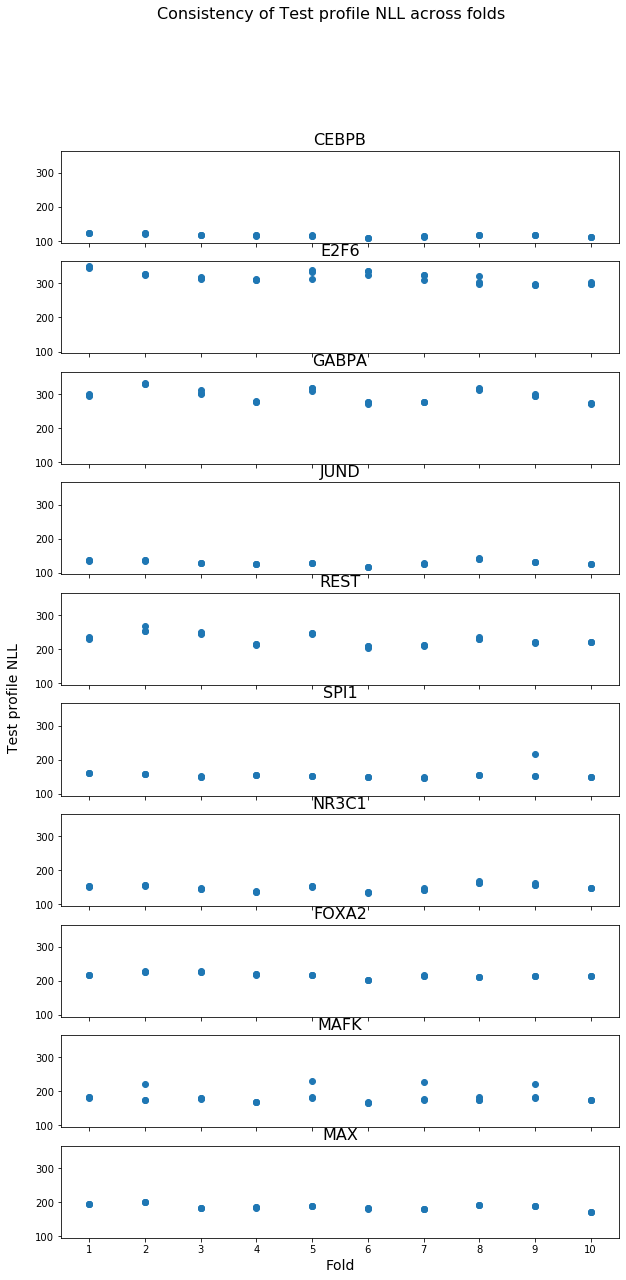

In [6]:
plot_fold_consistency(prof_nlls, "Test profile NLL")

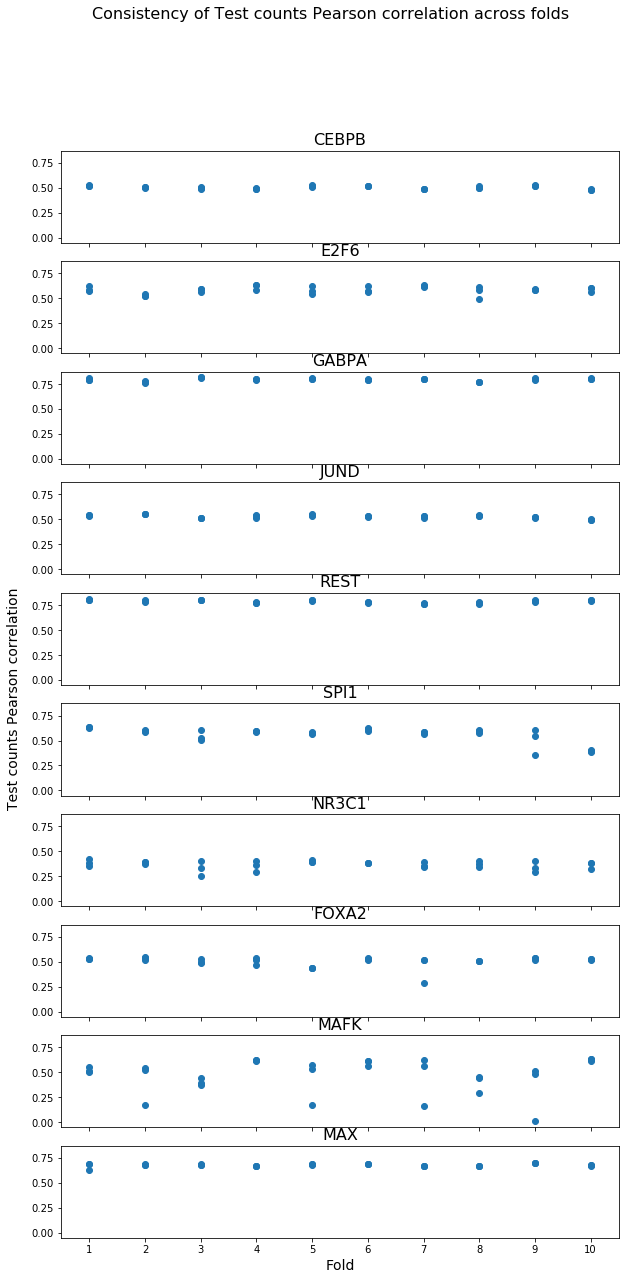

In [7]:
plot_fold_consistency(count_corrs, "Test counts Pearson correlation")